# Filtering Spam

In this project, we're going to build a spam filter for SMS messages. Our goal is select the best classification algorithm to filter new messages for spam.

To train the algorithm, we'll use a dataset of 5,572 SMS messages that are already classified by humans. The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

In [2]:
sms = pd.read_csv('/Users/turtle26mr/Desktop/smsspamcollection/SMSSpamCollection', sep= '\t', header = None, names=['label', 'message'] )

In [3]:
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Distrubution Spam/Non-spam
Let's look at our ratio of spam to non-spam messages

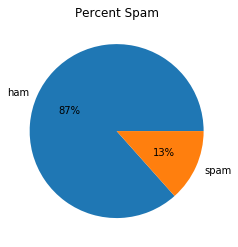

In [4]:
count_Class=pd.value_counts(sms["label"], sort= True)
count_Class.plot(kind = 'pie',  autopct='%1.0f%%')
plt.title('Percent Spam')
plt.ylabel('')
plt.show()

## Text Analytics
We want to find the frequencies of words in the spam and non-spam messages. The words of the messages will be model features.

We use the function Counter.


In [5]:
count1 = Counter(" ".join(sms[sms['label']=='ham']["message"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(sms[sms['label']=='spam']["message"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

In [6]:
df1.head

<bound method NDFrame.head of    words in non-spam  count
0                 to   1538
1                you   1462
2                  I   1439
3                the   1029
4                  a    977
5                  i    742
6                and    739
7                 in    736
8                  u    651
9                 is    645
10                my    621
11                me    541
12                of    499
13               for    481
14              that    399
15                it    376
16              your    374
17                on    352
18              have    349
19                at    334>

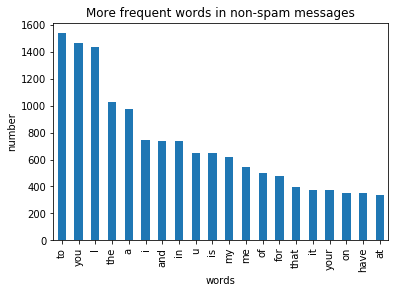

In [7]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

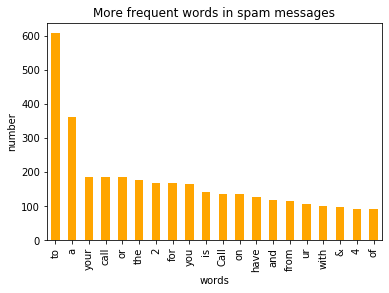

In [8]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in spam"]))
plt.xticks(y_pos, df2["words in spam"])
plt.title('More frequent words in spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

We can see that the majority of frequent words in both classes are stop words such as 'to', 'a', 'or' and so on.

## Pre-processing
We will focus on removing useless variance for our task at hand. First, we have to convert the labels from strings to binary values for our classifier:

In [9]:
sms['label'] = sms.label.map({'ham': 0, 'spam': 1})

In [10]:
sms.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Processing Continued
We need to clean up the text messages by coverting everthing to lower case and removing special characters.

In [11]:
sms['message'] = sms.message.map(lambda x: x.lower())
sms['message'] = sms.message.str.replace('[^\w\s]', '')

In [12]:
sms['message']

0       go until jurong point crazy available only in ...
1                                 ok lar joking wif u oni
2       free entry in 2 a wkly comp to win fa cup fina...
3             u dun say so early hor u c already then say
4       nah i dont think he goes to usf he lives aroun...
                              ...                        
5567    this is the 2nd time we have tried 2 contact u...
5568                  will ü b going to esplanade fr home
5569    pity  was in mood for that soany other suggest...
5570    the guy did some bitching but i acted like id ...
5571                            rofl its true to its name
Name: message, Length: 5572, dtype: object

## Word Stemming
The idea of stemming is to normalize our text for all variations of words carry the same meaning, regardless of the tense. For example, 'call', 'calling', and 'called' all have the same root meaning and wil be treated the same. Having individual dictionary entries per version would be highly redundant and inefficient, especially since, once we convert to numbers, the "value" is going to be identical. We shall import 'PorterStemmer' from the Natural Language Toolkit \(nltk\).


In [13]:
stemmer = PorterStemmer()
sms['message'] = sms['message'].str.split()
sms['message'] = sms['message'].apply(lambda x: [stemmer.stem(y) for y in x])

In [27]:
sms

,label,message
0,0,go until jurong point crazi avail onli in bugi...
1,0,ok lar joke wif u oni
2,1,free entri in 2 a wkli comp to win fa cup fina...
3,0,u dun say so earli hor u c alreadi then say
4,0,nah i dont think he goe to usf he live around ...
...,...,...
5567,1,thi is the 2nd time we have tri 2 contact u u ...
5568,0,will ü b go to esplanad fr home
5569,0,piti wa in mood for that soani other suggest
5570,0,the guy did some bitch but i act like id be in...


## Word counts from text using a vectorizer  
We cannot work with text directly, instead, we need to convert the text to numbers.
The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.
The CountVectorizer transformer from the sklearn.feature_extraction model has its own internal tokenization and normalization methods. The fit method of the vectorizer expects an iterable or list of strings or file objects, and creates a dictionary of the vocabulary from the text. When transform is called, each individual document is transformed into a sparse array whose index tuple is the row (the document ID) and the token ID from the dictionary, and whose value is the count

We saw earlier that the majority of frequent words in both classes are stop words such as 'to', 'a', 'or' and so on.

We include 'stop words' in our count vector to remove these common words.

In [15]:
# This converts the list of words into space-separated strings
sms['message'] = sms['message'].apply(lambda x: ' '.join(x))

count_vect = CountVectorizer(stop_words = 'english')
counts = count_vect.fit_transform(sms['message'])

Now that our data is processed, we can fit it to a machine learning algorithm

## Naive Bayes 

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features.
It is based on Bayes Theorem. Bayes’ theorem states the following relationship, given class variable, y,  and dependent feature vector x(1), through x(n):
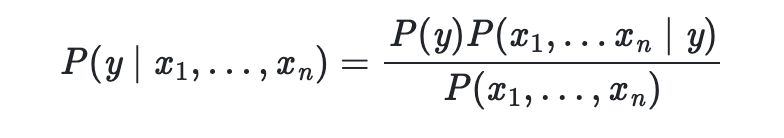


Using the naive conditional independence assumption that all xis are independent 

for all i, this relationship is simplified to

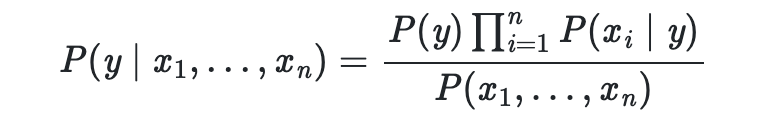

Since P(xi .... xn) is constant given the input, we can use the following classification rule:
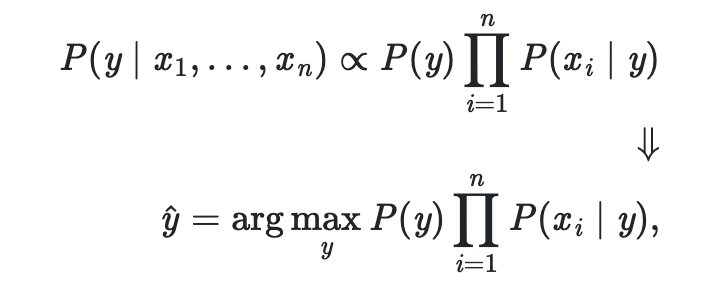

For our project, we will start with multinomial naive Bayes:

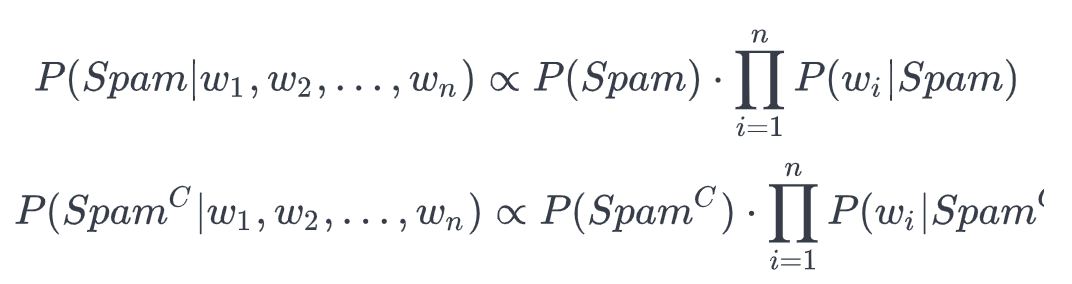
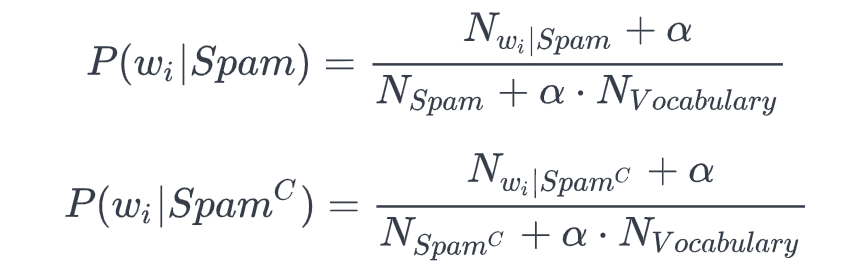



## Training the Model
Now that we have performed feature extraction from our data, it is time to build our model. We will start by splitting our data into training and test sets.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(counts, sms['label'], test_size=0.1, random_state=1)

model = MultinomialNB().fit(X_train, y_train)

## Evaluating the Model
We can now test our model on out test set

In [17]:
predicted = model.predict(X_test)

print(np.mean(predicted == y_test))

0.9874551971326165


## Confusion Matrix
Our simple Naive Bayes Classifier has 98.7 % accuracy with this specific test set! But it is not enough by just providing the accuracy, since our dataset is imbalanced when it comes to the labels (86.6% legitimate in contrast to 13.4% spam). It could happen that our classifier is over-fitting the legitimate class while ignoring the spam class. To solve this uncertainty, let's have a look at the confusion matrix:

In [18]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, predicted))

[[483   6]
 [  1  68]]


As we can see, the amount of errors is fairly low for legitimate and spam, with 6 legitimate messages classified as spam and 1 spam messages classified as legitimate. Overall, these are very good results for our simple classifier.

## AUC- ROC Curve

To get an even better idea how our model is preforming, we can look at the AUC-ROC curve.

AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s.


In [19]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

# Measure the area under the curve
# The closer to 1 it is, the "better" the predictions
print("AUC of the predictions: {0}".format(roc_auc))

AUC of the predictions: 0.9866186538632524


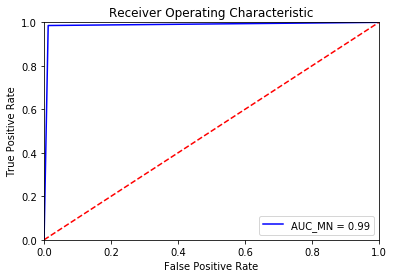

In [20]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC_MN = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Other Classifiers
We should try others binary classifiers to see if they perform better. Bernoulli Naive Bayes differs from multinomial NB’s rule in that it explicitly penalizes the non-occurrence of a feature, i, where the multinomial variant would simply ignore a non-occurring feature. We can also look at logistic regression, random forest, and the K nearest neighbors.

In [21]:
classifiers = [MultinomialNB(),
        BernoulliNB(),
        RandomForestClassifier(n_estimators=100, n_jobs=-1),
        LogisticRegression(),
        KNeighborsClassifier()]

In [22]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for classifier in classifiers:
        model = classifier.fit(X_train, y_train)
        predicted = model.predict(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted, pos_label=1)
        auc = metrics.auc(fpr, tpr)
        result_table = result_table.append({'classifiers':classifier.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
        print("AUC of the predictions: {0}".format(auc))
        
# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)         
        
      

AUC of the predictions: 0.9866186538632524
AUC of the predictions: 0.9296701342580244
AUC of the predictions: 0.927536231884058
AUC of the predictions: 0.9202898550724637
AUC of the predictions: 0.717391304347826


/Users/turtle26mr/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


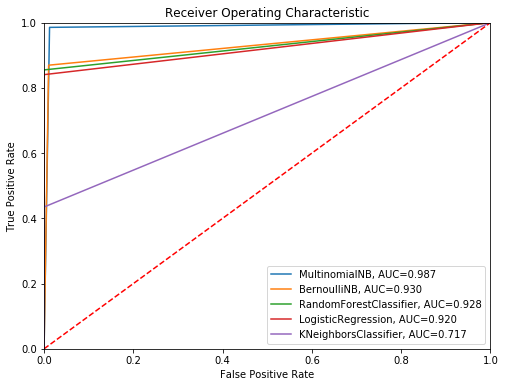

In [23]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()    

## Next Steps
We can randomize the data set to see if that has an effect on our results. Additionally we examine other classifiers and vectorizers.

In [24]:
# Randomize the dataset
data_randomized = sms.sample(frac=1, random_state=1)
training_test_index = round(len(data_randomized) * 0.8)

# Training/Test split
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)


(4458, 2)
(1114, 2)


In [25]:
def perform(classifiers, vectorizers, train_data, test_data):
    for classifier in classifiers:
        for vectorizer in vectorizers:
            string = ''
            string += classifier.__class__.__name__ + ' with ' + vectorizer.__class__.__name__

            # train
            vectorize_text = vectorizer.fit_transform(train_data['message'])
            classifier.fit(vectorize_text, train_data['label'])

            # score
            vectorize_text = vectorizer.transform(test_data['message'])
            score = classifier.score(vectorize_text, test_data['label'])
            string += '. Has score: ' + str(score)
            print(string)

In [26]:
perform(
   classifiers,
    [
        CountVectorizer(),
        TfidfVectorizer()
    ],
    training_set,
    test_set
)

MultinomialNB with CountVectorizer. Has score: 0.9766606822262118
MultinomialNB with TfidfVectorizer. Has score: 0.9569120287253142
BernoulliNB with CountVectorizer. Has score: 0.973967684021544
BernoulliNB with TfidfVectorizer. Has score: 0.973967684021544
RandomForestClassifier with CountVectorizer. Has score: 0.973967684021544
RandomForestClassifier with TfidfVectorizer. Has score: 0.973967684021544
LogisticRegression with CountVectorizer. Has score: 0.9784560143626571


/Users/turtle26mr/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/turtle26mr/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression with TfidfVectorizer. Has score: 0.9703770197486535
KNeighborsClassifier with CountVectorizer. Has score: 0.9210053859964094
KNeighborsClassifier with TfidfVectorizer. Has score: 0.9156193895870736


## Conclusion
The Multinomial naive Bayes performs the best of all the algorithms and vectorizers we tested. Our recommendation would be to use Multinomial naive Bayes for new spam filtering